In [1]:
import datetime
import time
import uuid

import numpy as np
# package(s) for data handling
import pandas as pd
import shapely.geometry
import simpy

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot

# setup environment
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)
registry = {}

In [2]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasMultiContainer,
        core.HasResource,
    ),
    {},
)

TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.MultiContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {"key": "MultiStoreHopper"},
)

In [3]:
N = 400
n = 200

location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

from_site = Site(
    env=my_env,
    name="Winlocatie",
    ID=str(uuid.uuid4()),
    geometry=location_from_site,
    store_capacity=4,
    nr_resources=1,
    initials=[
        {"id": "MP", "level": N-n, "capacity": N},
    ],
)

in_between = Site(
    env=my_env,
    name="Overslag",
    ID=str(uuid.uuid4()),
    geometry=location_to_site,
    store_capacity=4,
    nr_resources=1,
    initials=[
        {"id": "MP", "level": n, "capacity": N},
    ],
)


to_site = Site(
    env=my_env,
    name="Dumplocatie",
    ID=str(uuid.uuid4()),
    geometry=location_to_site,
    store_capacity=4,
    nr_resources=1,
    initials=[
        {"id": "MP", "level": 0, "capacity": N},
    ],
)

In [4]:
vessel_1 = TransportProcessingResource(
    env=my_env,
    name="Vessel 01",
    ID=str(uuid.uuid4()),
    geometry=location_from_site,
    store_capacity=4,
    nr_resources=1,
    compute_v=lambda x: 10,
    initials=[
        {"id": "MP", "level": 0, "capacity": 1},
    ],
)
vessel_2 = TransportProcessingResource(
    env=my_env,
    name="Vessel 02",
    ID=str(uuid.uuid4()),
    geometry=location_from_site,
    store_capacity=4,
    nr_resources=1,
    compute_v=lambda x: 10,
    initials=[
        {"id": "MP", "level": 0, "capacity": 1},
    ],
)

processes = []
proc_1_vessels = []
proc_2_vessels = []
i=10
j=10

In [5]:

for i in range(i):
    vessel = TransportProcessingResource(
        env=my_env,
        name=f"proc 1 Vessel {i}",
        ID=str(uuid.uuid4()),
        geometry=location_from_site,
        store_capacity=4,
        nr_resources=1,
        compute_v=lambda x: 10,
        initials=[
            {"id": "MP", "level": 0, "capacity": 1},
        ],
    )
    proc_1_vessels.append(vessel)
    requested_resources1 = {}
    proc_1 = model.WhileActivity(
        env=my_env,
        name=f"while {vessel.name}",
        ID=str(uuid.uuid4()),
        registry=registry,
        reserve_activities=True,
        sub_processes=[
            model.SequentialActivity(
                env=my_env,
                name=f"sequence {vessel.name}",
                ID=str(uuid.uuid4()),
                registry=registry,
                sub_processes=[
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty {vessel.name}",
                        ID=str(uuid.uuid4()),
                        registry=registry,
                        mover=vessel,
                        destination=from_site,
                        duration=10,
                        requested_resources=requested_resources1,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"Load MP {vessel.name}",
                        ID=str(uuid.uuid4()),
                        registry=registry,
                        processor=vessel,
                        origin=from_site,
                        destination=vessel,
                        amount=1,
                        duration=10,
                        id_="MP",
                        requested_resources=requested_resources1,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing filled {vessel.name}",
                        ID=str(uuid.uuid4()),
                        registry=registry,
                        mover=vessel,
                        destination=in_between,
                        duration=10,
                        requested_resources=requested_resources1,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"Transfer MP {vessel.name}",
                        ID=str(uuid.uuid4()),
                        registry=registry,
                        processor=vessel,
                        origin=vessel,
                        destination=in_between,
                        amount=1,
                        duration=10,
                        id_="MP",
                        requested_resources=requested_resources1,
                    ),
                ],
            )
        ],
        condition_event={"type": "container","concept": from_site,"state": "empty", "id_":"MP"},
    )
    processes.append(proc_1)

In [6]:

for i in range(j):
    vessel = TransportProcessingResource(
        env=my_env,
        name=f"proc 2 Vessel {i}",
        ID=str(uuid.uuid4()),
        geometry=location_from_site,
        store_capacity=4,
        nr_resources=1,
        compute_v=lambda x: 10,
        initials=[
            {"id": "MP", "level": 0, "capacity": 1},
        ],
    )
    proc_2_vessels.append(vessel)
    requested_resources1 = {}
    proc_2 = model.WhileActivity(
        env=my_env,
        name=f"while {vessel.name}",
        ID=str(uuid.uuid4()),
        reserve_activities=True,
        registry=registry,
        sub_processes=[
            model.SequentialActivity(
                env=my_env,
                name=f"sequence {vessel.name}",
                ID=str(uuid.uuid4()),
                registry=registry,
                sub_processes=[
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty {vessel.name}",
                        ID=str(uuid.uuid4()),
                        registry=registry,
                        mover=vessel,
                        destination=in_between,
                        duration=10,
                        requested_resources=requested_resources1,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"Load MP {vessel.name}",
                        ID=str(uuid.uuid4()),
                        registry=registry,
                        processor=vessel,
                        origin=in_between,
                        destination=vessel,
                        amount=1,
                        duration=10,
                        id_="MP",
                        requested_resources=requested_resources1,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing filled {vessel.name}",
                        ID=str(uuid.uuid4()),
                        registry=registry,
                        mover=vessel,
                        destination=to_site,
                        duration=10,
                        requested_resources=requested_resources1,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"Transfer MP {vessel.name}",
                        ID=str(uuid.uuid4()),
                        registry=registry,
                        processor=vessel,
                        origin=vessel,
                        destination=to_site,
                        amount=1,
                        duration=10,
                        id_="MP",
                        requested_resources=requested_resources1,
                    ),
                ],
            )
        ],
        condition_event={"type": "container","concept": to_site,"state": "full", "id_":"MP"},
    )
    processes.append(proc_2)

In [7]:
model.register_processes([
    *processes
])
my_env.run()

In [8]:
acts = []
for p in processes:
    acts.extend(p.sub_processes[0].sub_processes)
    
plot.vessel_planning(acts)

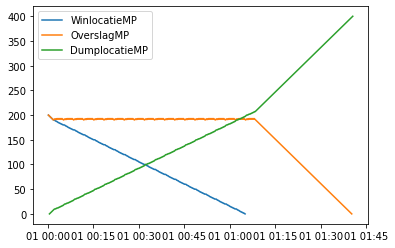

In [9]:
fig = plot.get_step_chart([from_site,in_between, to_site])